In [21]:
from src.config import DATA_DIR
import h5py
import numpy as np
import matplotlib.pyplot as plt



In [22]:
f = h5py.File(DATA_DIR+"/recording_20240611_184319.h5",'r')

In [23]:
timestamps = np.array(f["timestamps"])
images = np.array(f['images'])
poses = np.array(f['poses'])

In [24]:
print(timestamps[:10])

[1718124193089 1718124193122 1718124193156 1718124193189 1718124193223
 1718124193256 1718124193289 1718124193323 1718124193356 1718124193390]


In [25]:
poses.shape

(181, 4, 4)

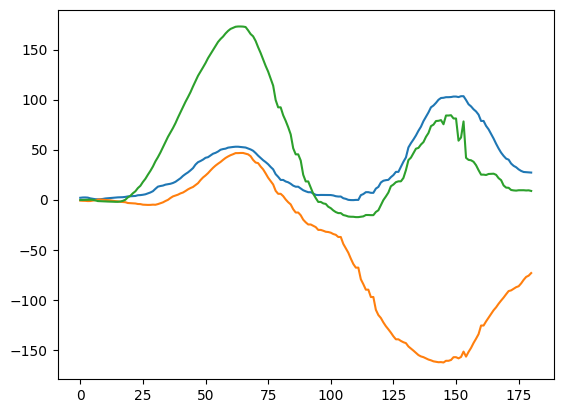

In [27]:
plt.plot(poses[:,:3,3])

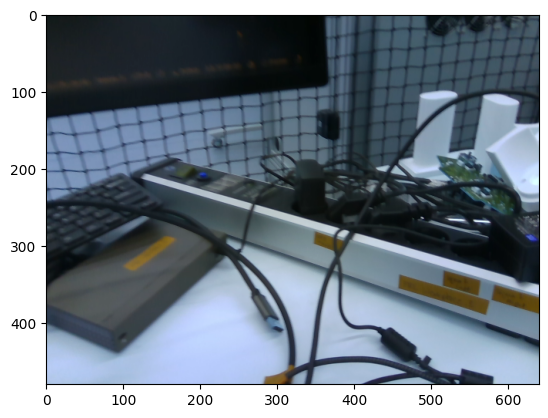

In [31]:
plt.imshow(images[50])

In [ ]:
%matplotlib widget
import h5py
import mediapy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from spatialmath import *

In [ ]:
path='recording.hdf5'
f = h5py.File(path,'r')

In [ ]:
#images = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in f['images']]

#mediapy.show_video(images, fps=30)

In [ ]:
poses = np.array(f['poses'])
pose_confidences = f['poses'].attrs['pose_confidences']

cam_pos =  poses[:,:3,3]

color = [str(i/100) for i in pose_confidences]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(*cam_pos[0,:3], c='red', marker='o')
ax.scatter(cam_pos[:,0], cam_pos[:,1], cam_pos[:,2], c=color, marker='.')

plt.show()


In [ ]:
poses[0].shape
